In [1]:
# Drive Mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

# Check path
!pwd

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive


# Create spectrogram images

In [2]:
import os
import glob
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# Check number of wav files
train_healthy_paths = list(glob.glob('./SVD/train/healthy/*.wav'))
train_pathology_paths = list(glob.glob('./SVD/train/pathology/*.wav'))
test_healthy_paths = list(glob.glob('./SVD/test/healthy/*.wav'))
test_pathology_paths = list(glob.glob('./SVD/test/pathology/*.wav'))
print(f'train healthy   : {len(train_healthy_paths)} audios')
print(f'train_pathology : {len(train_pathology_paths)} audios')
print(f'test_healthy    : {len(test_healthy_paths)} audios')
print(f'test_pathology  : {len(test_pathology_paths)} audios')

train healthy   : 532 audios
train_pathology : 762 audios
test_healthy    : 100 audios
test_pathology  : 100 audios


In [4]:
# Plot waveform(amplitude) of path file
def plot_waveform(path):
    name = os.path.basename(path) # return file name on path ex) audio1.wav
    # .wav file has two basic meta data
    # waveform : contains the waveform information of the time series [1, N] size.
    # sample_rate : typically has a sample rate of 44.1 kHz.
    waveform, sample_rate = torchaudio.load(path)
    print(f'{name}')
    print(f'Shape of waveform: {waveform.shape}')
    print(f'Sample rate: {sample_rate}')
    plt.figure()
    plt.plot(waveform[0].numpy())

In [5]:
# Plot spectrogram of path file(wav)
def show_spectrogram(path):
    name = os.path.basename(path)
    print(f'{name}')
    waveform, sample_rate = torchaudio.load(path)
    # n_fft means FFT's windows size
    # when size get bigger, frequency resolution increases and otherwise, decreases. trade-off relationship.
    # The value that is typically used at 512.
    spectrogram = T.Spectrogram(n_fft=512) # Define transform
    spec = spectrogram(waveform) # Perform transform
    plt.figure()
    plt.imshow(librosa.power_to_db(spec[0]), origin='lower') # ploting

12-phrase.wav
Shape of waveform: torch.Size([1, 78067])
Sample rate: 50000


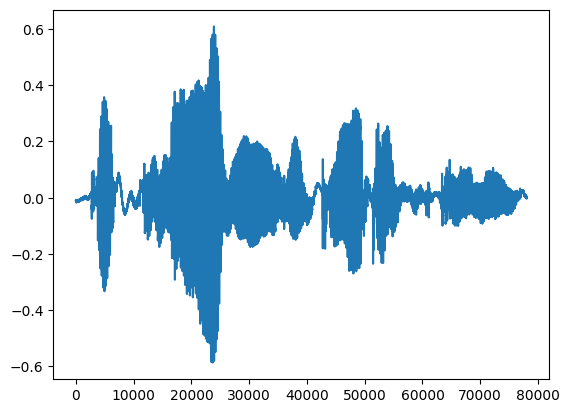

In [6]:
# healthy example
path = train_healthy_paths[1] # take a healthy sample. (12-phrase.wav)
plot_waveform(path) # use above function, draw waveform graph.
waveform, sample_rate = torchaudio.load(path)
ipd.Audio(waveform[0].numpy(), rate=sample_rate)
# Audio Length might be sample size / sample rate == 78067 / 50000 ≈ 1.56 seconds.

12-phrase.wav


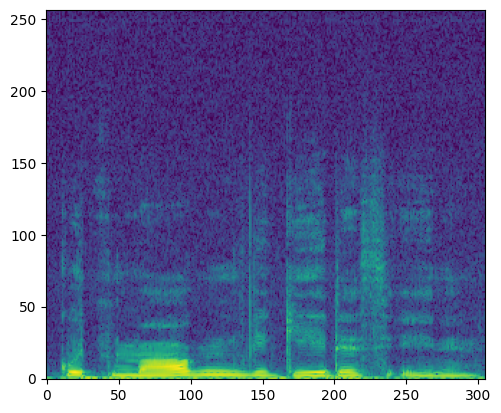

In [7]:
# healthy example
show_spectrogram(path)

In [8]:
# Define function to make datasets
def load_audios(paths):
    paths = paths
    dataset = []
    for p in paths:
        name = os.path.basename(p) # extract file names at each path.
        name = os.path.splitext(name)[0] # remove extensions so left only file names.
        waveform, sample_rate = torchaudio.load(p) # get meta data,
        dataset.append([waveform, sample_rate, name]) # append meta data on list.

    return dataset

In [9]:
# make datasets
h_train = load_audios(train_healthy_paths)
p_train = load_audios(train_pathology_paths)
h_test = load_audios(test_healthy_paths)
p_test = load_audios(test_pathology_paths)

In [10]:
# create loader objects.
# test sets don't have to shuffle
loader_h_train = DataLoader(h_train, batch_size=1, shuffle=False)
loader_p_train = DataLoader(p_train, batch_size=1, shuffle=False)
loader_h_test = DataLoader(h_test, batch_size=1, shuffle=False)
loader_p_test = DataLoader(p_test, batch_size=1, shuffle=False)

In [11]:
# define create spectrogram image function
def create_spectrogram_images(loader, label, t):
    dir = f'./SVD/spectrograms/{t}/{label}'
    if os.path.isdir(dir): # check directory exists already.
        print(f'Data exists for {label}')
    else:
        os.makedirs(dir, exist_ok=True)
        for data in loader: # loader object iteration
            waveform = data[0][0] # speech data
            name = data[2][0] # file name
            spectrogram = T.Spectrogram(n_fft=512) # transform object define.
            spec = spectrogram(waveform) # spectrogram 2D data. could checked through plt.imshow().
            fig = plt.figure()
            plt.imshow(librosa.power_to_db(spec[0]), origin='lower')
            plt.axis('off') # The axis interferes training
            # bbox_inches='tight' : minimize white margins
            # pad_inches=0 : simillar with above line
            plt.savefig(f'./SVD/spectrograms/{t}/{label}/{name}.png',
                        bbox_inches='tight', pad_inches=0)
            plt.close()

In [12]:
# create spectrogram image (take about 5 mins)
create_spectrogram_images(loader_h_train, 'healthy', 'train')
create_spectrogram_images(loader_p_train, 'pathology', 'train')
create_spectrogram_images(loader_h_test, 'healthy', 'test')
create_spectrogram_images(loader_p_test, 'pathology', 'test')

Data exists for healthy
Data exists for pathology
Data exists for healthy
Data exists for pathology


In [13]:
# check num of image files
train_healthy_images = list(glob.glob('./SVD/spectrograms/train/healthy/*.png'))
train_pathology_images = list(glob.glob('./SVD/spectrograms/train/pathology/*.png'))
test_healthy_images = list(glob.glob('./SVD/spectrograms/test/healthy/*.png'))
test_pathology_images = list(glob.glob('./SVD/spectrograms/test/pathology/*.png'))
print(f'train healthy   : {len(train_healthy_images)} images')
print(f'train_pathology : {len(train_pathology_images)} images')
print(f'test_healthy    : {len(test_healthy_images)} images')
print(f'test_pathology  : {len(test_pathology_images)} images')

train healthy   : 532 images
train_pathology : 762 images
test_healthy    : 100 images
test_pathology  : 100 images
